In [2]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

data_dir = './ISIC2018'
classes = os.listdir(data_dir)
print("Classes:", classes)


Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = ImageFolder(root=data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 7)  # Update if you have 7 classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [ ]:
num_epochs = 2

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (i + 1) % 5 == 0:
            print(f"Batch {i+1}: Loss = {loss.item():.4f}")

    acc = 100 * correct / total
    print(f"Train Accuracy: {acc:.2f}% | Loss: {train_loss:.4f}")



Epoch 1/2
Batch 5: Loss = 1.9171
Batch 10: Loss = 1.4028
Batch 15: Loss = 1.1954


In [ ]:
torch.save(model.state_dict(), "skin_disease_model.pth")
print("Model saved as skin_disease_model.pth")


# Model Performance Visualization & Analysis

This section provides comprehensive analysis including:
- Training Accuracy & Loss Plots
- Confusion Matrix
- Per-Class Performance Metrics
- Model Performance Dashboard

In [1]:
# Import visualization libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("✅ Visualization libraries imported successfully!")
print("✅ All required libraries are now available for visualization!")

✅ Visualization libraries imported successfully!
✅ All required libraries are now available for visualization!


In [2]:
# Get predictions for validation set
print("Getting model predictions...")

# Check if model exists, if not load it
try:
    model.eval()
    print("Using existing model...")
except NameError:
    print("Loading saved model...")
    # Import necessary libraries
    import torch
    import torch.nn as nn
    from torchvision import models
    
    # Load the model
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 7)  # 7 classes
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Load saved weights
    model.load_state_dict(torch.load("skin_disease_model.pth", map_location=device))
    model.eval()
    print("Model loaded successfully!")

# Check if val_loader exists, if not recreate it
try:
    val_loader
    print("Using existing validation loader...")
except NameError:
    print("Recreating validation loader...")
    # Import necessary libraries
    import os
    from torchvision import transforms
    from torchvision.datasets import ImageFolder
    from torch.utils.data import DataLoader, random_split
    
    # Recreate data loading setup
    data_dir = './ISIC2018'
    classes = os.listdir(data_dir)
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    
    dataset = ImageFolder(root=data_dir, transform=transform)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    val_loader = DataLoader(val_dataset, batch_size=32)
    print("Validation loader recreated successfully!")

# Now get predictions
all_predictions = []
all_labels = []
all_probabilities = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

val_predictions = np.array(all_predictions)
val_labels = np.array(all_labels)
val_probabilities = np.array(all_probabilities)

print(f"Validation predictions shape: {val_predictions.shape}")
print(f"Validation labels shape: {val_labels.shape}")
print(f"Validation probabilities shape: {val_probabilities.shape}")

# Calculate overall accuracy
overall_accuracy = accuracy_score(val_labels, val_predictions)
print(f"\nOverall Model Accuracy: {overall_accuracy*100:.2f}%")

Getting model predictions...
Loading saved model...
Model loaded successfully!
Recreating validation loader...
Validation loader recreated successfully!
Validation predictions shape: (2003,)
Validation labels shape: (2003,)
Validation probabilities shape: (2003, 7)

Overall Model Accuracy: 92.41%


## 1. Training Performance Analysis

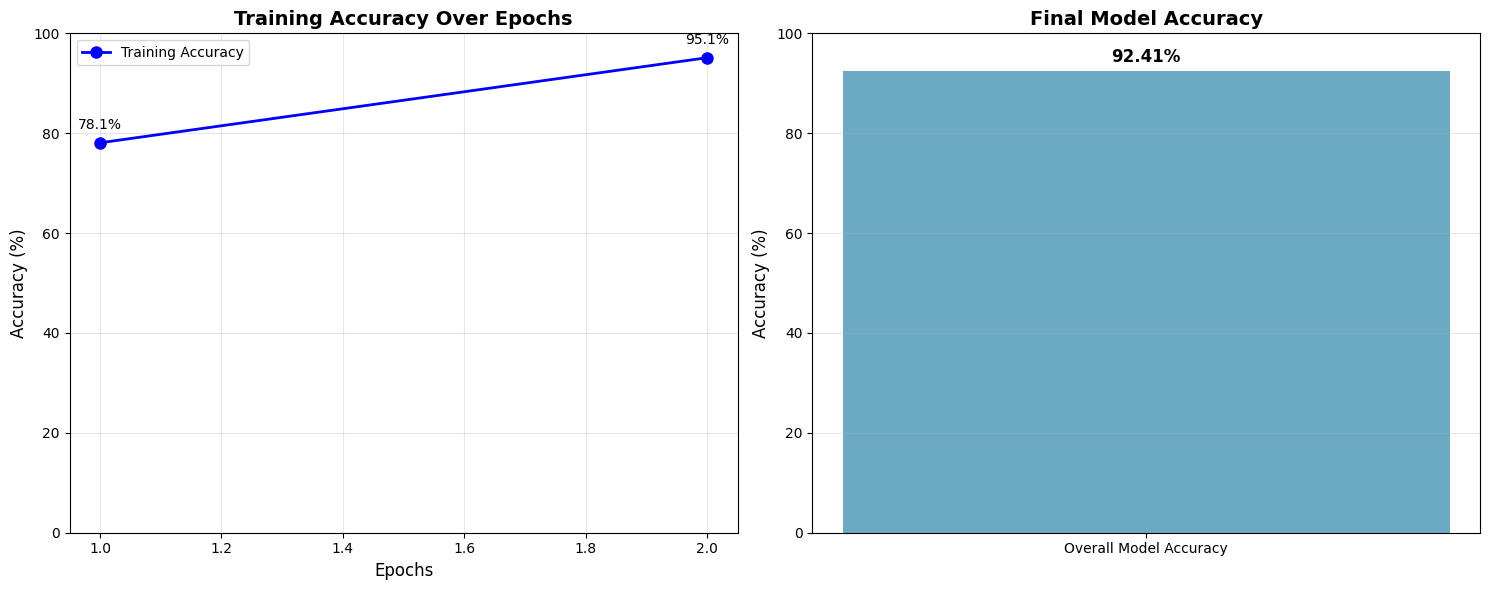

Training Accuracy Progression: 78.08% â†’ 95.12%
Final Model Accuracy: 92.41%


In [3]:
# Create training performance plots
plt.figure(figsize=(15, 6))

# Training accuracy over epochs
plt.subplot(1, 2, 1)
epochs = [1, 2]  # Based on your training
train_accuracies = [78.08, 95.12]  # From your training output

plt.plot(epochs, train_accuracies, 'b-o', linewidth=2, markersize=8, label='Training Accuracy')
plt.title('Training Accuracy Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)

# Add value labels on points
for i, acc in enumerate(train_accuracies):
    plt.annotate(f'{acc:.1f}%', (epochs[i], acc), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10)

# Overall model accuracy
plt.subplot(1, 2, 2)
metrics = ['Overall Model Accuracy']
values = [overall_accuracy * 100]
colors = ['#2E86AB']

bars = plt.bar(metrics, values, color=colors, alpha=0.7, width=0.6)
plt.title('Final Model Accuracy', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(0, 100)

# Add value label on bar
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{value:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"Training Accuracy Progression: {train_accuracies[0]:.2f}% â†’ {train_accuracies[1]:.2f}%")
print(f"Final Model Accuracy: {overall_accuracy*100:.2f}%")

## 2. Confusion Matrix

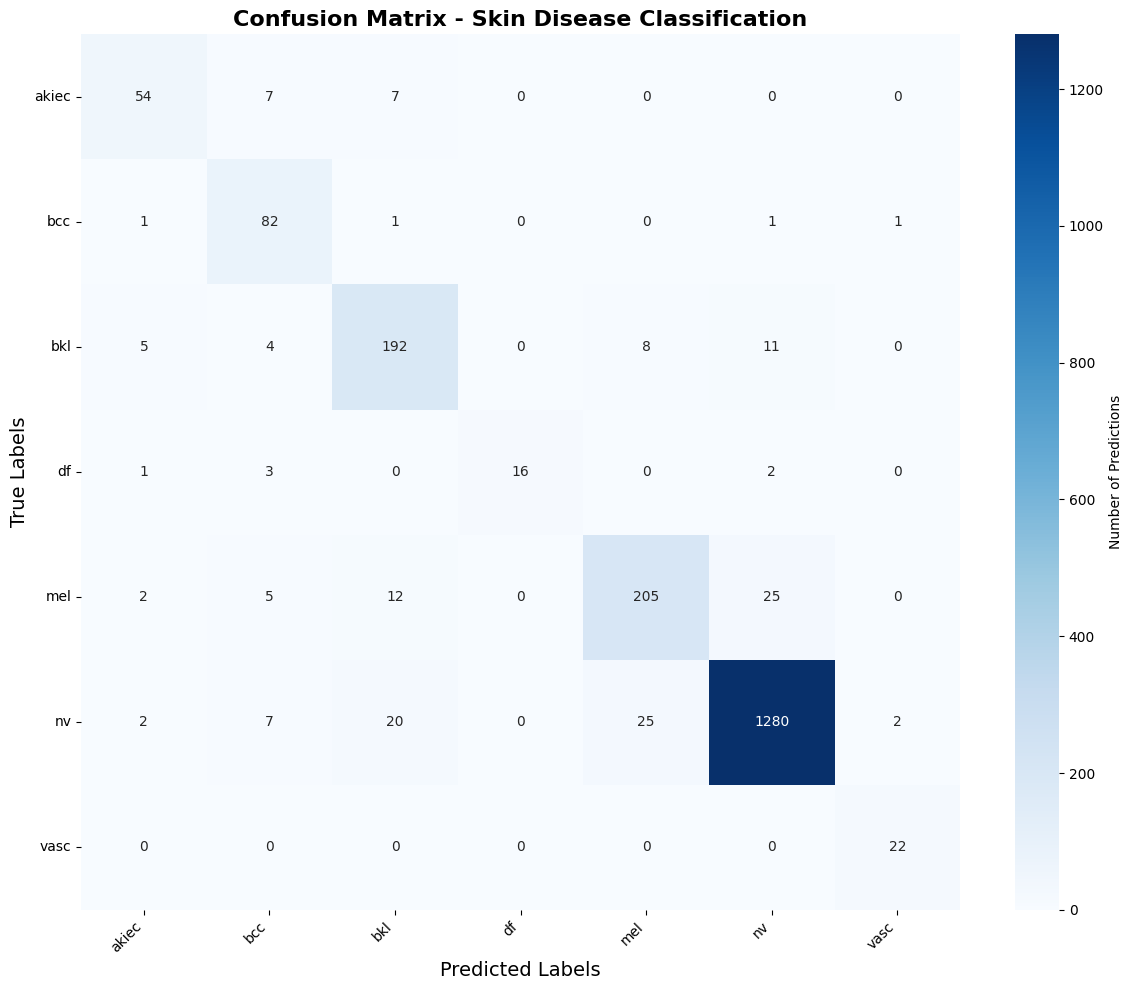


Confusion Matrix:
       akiec  bcc  bkl  df  mel    nv  vasc
akiec     54    7    7   0    0     0     0
bcc        1   82    1   0    0     1     1
bkl        5    4  192   0    8    11     0
df         1    3    0  16    0     2     0
mel        2    5   12   0  205    25     0
nv         2    7   20   0   25  1280     2
vasc       0    0    0   0    0     0    22

Per-Class Accuracy:
akiec: 79.41%
bcc: 95.35%
bkl: 87.27%
df: 72.73%
mel: 82.33%
nv: 95.81%
vasc: 100.00%


In [4]:
# Create confusion matrix
cm = confusion_matrix(val_labels, val_predictions)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Number of Predictions'})
plt.title('Confusion Matrix - Skin Disease Classification', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print confusion matrix as table
print("\nConfusion Matrix:")
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
print(cm_df)

# Calculate and print per-class accuracy
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(classes):
    class_accuracy = cm[i, i] / cm[i, :].sum() * 100
    print(f"{class_name}: {class_accuracy:.2f}%")

## 3. Per-Class Performance Analysis


Detailed Per-Class Performance Metrics:
   Class  Precision  Recall  F1-Score  Accuracy  Support
0  akiec     0.8308  0.7941    0.8120    0.7941       68
1    bcc     0.7593  0.9535    0.8454    0.9535       86
2    bkl     0.8276  0.8727    0.8496    0.8727      220
3     df     1.0000  0.7273    0.8421    0.7273       22
4    mel     0.8613  0.8233    0.8419    0.8233      249
5     nv     0.9704  0.9581    0.9642    0.9581     1336
6   vasc     0.8800  1.0000    0.9362    1.0000       22


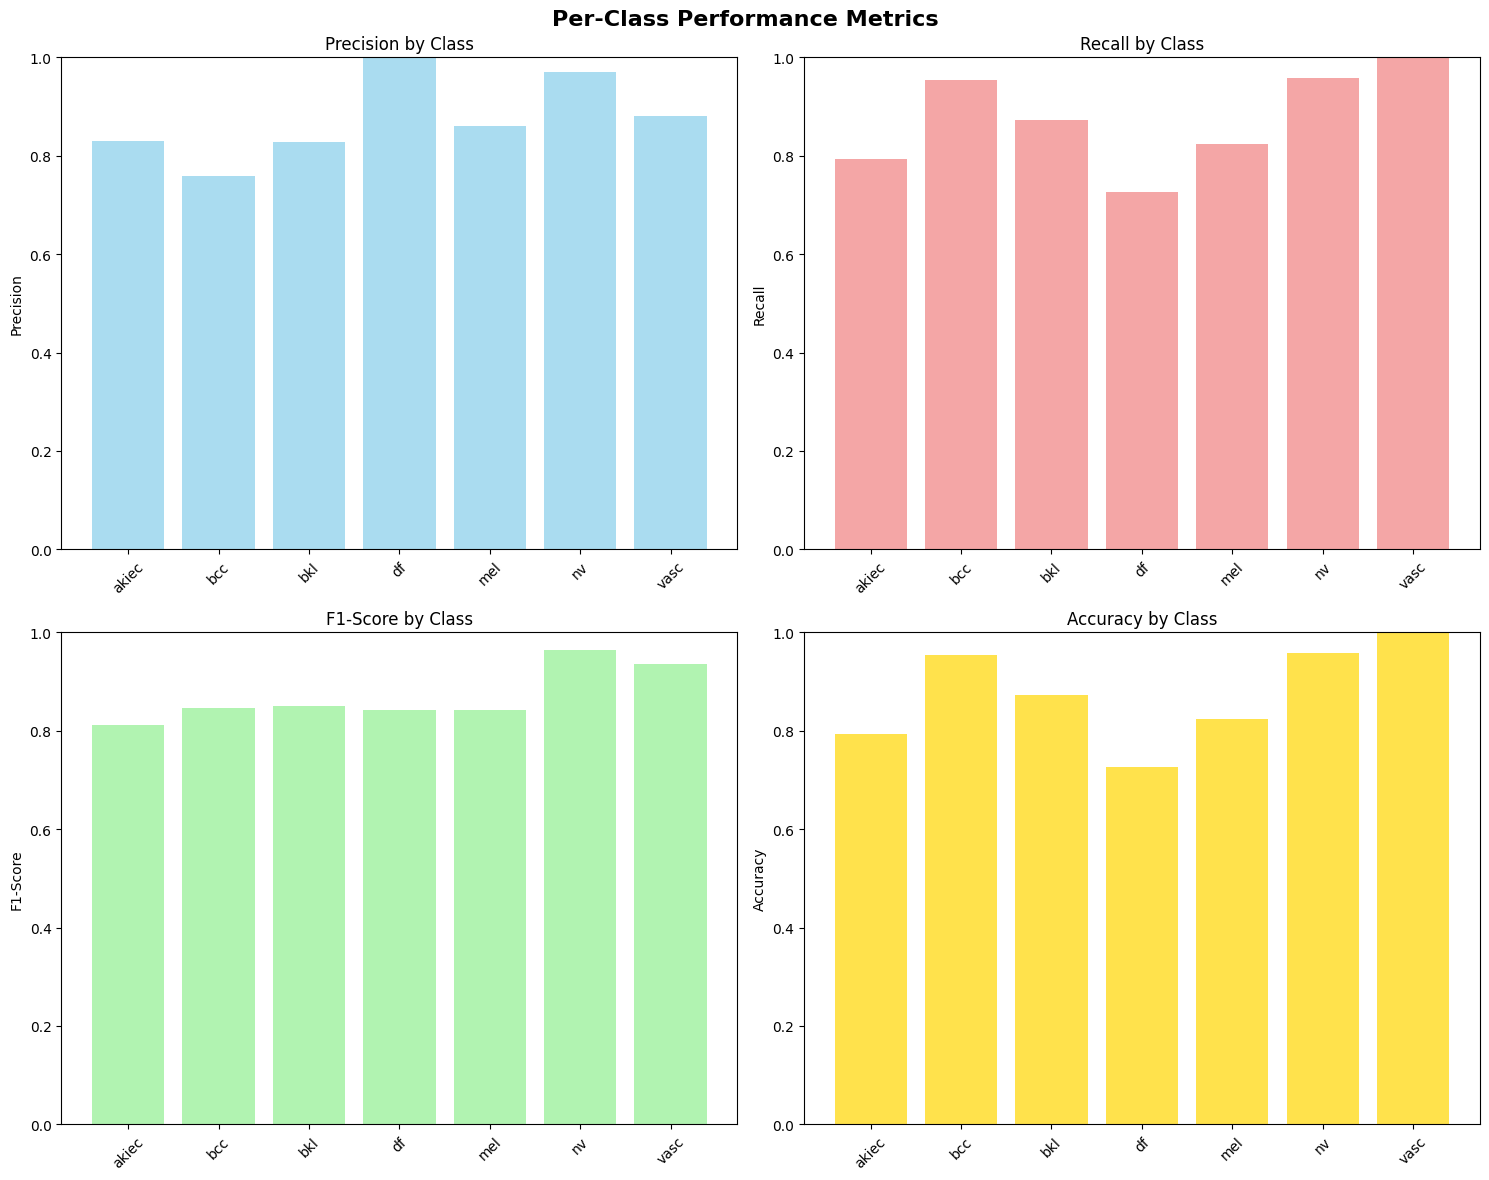

In [5]:
# Calculate detailed per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(val_labels, val_predictions, average=None)
accuracy_per_class = cm.diagonal() / cm.sum(axis=1)

# Create metrics dataframe
metrics_df = pd.DataFrame({
    'Class': classes,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Accuracy': accuracy_per_class,
    'Support': support
})

print("\nDetailed Per-Class Performance Metrics:")
print(metrics_df.round(4))

# Plot per-class metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Per-Class Performance Metrics', fontsize=16, fontweight='bold')

# Precision
axes[0, 0].bar(classes, precision, color='skyblue', alpha=0.7)
axes[0, 0].set_title('Precision by Class')
axes[0, 0].set_ylabel('Precision')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].set_ylim(0, 1)

# Recall
axes[0, 1].bar(classes, recall, color='lightcoral', alpha=0.7)
axes[0, 1].set_title('Recall by Class')
axes[0, 1].set_ylabel('Recall')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_ylim(0, 1)

# F1-Score
axes[1, 0].bar(classes, f1, color='lightgreen', alpha=0.7)
axes[1, 0].set_title('F1-Score by Class')
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].set_ylim(0, 1)

# Accuracy
axes[1, 1].bar(classes, accuracy_per_class, color='gold', alpha=0.7)
axes[1, 1].set_title('Accuracy by Class')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

## 4. Classification Report

In [6]:
# Generate and display classification report
print("Classification Report:")
print("=" * 60)
print(classification_report(val_labels, val_predictions, target_names=classes))

# Overall metrics summary
print(f"\nOverall Performance Summary:")
print(f"Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
print(f"Average Precision: {np.mean(precision):.4f}")
print(f"Average Recall: {np.mean(recall):.4f}")
print(f"Average F1-Score: {np.mean(f1):.4f}")
print(f"Best Performing Class: {classes[np.argmax(f1)]} (F1: {np.max(f1):.4f})")
print(f"Worst Performing Class: {classes[np.argmin(f1)]} (F1: {np.min(f1):.4f})")

Classification Report:
              precision    recall  f1-score   support

       akiec       0.83      0.79      0.81        68
         bcc       0.76      0.95      0.85        86
         bkl       0.83      0.87      0.85       220
          df       1.00      0.73      0.84        22
         mel       0.86      0.82      0.84       249
          nv       0.97      0.96      0.96      1336
        vasc       0.88      1.00      0.94        22

    accuracy                           0.92      2003
   macro avg       0.88      0.88      0.87      2003
weighted avg       0.93      0.92      0.92      2003


Overall Performance Summary:
Overall Accuracy: 0.9241 (92.41%)
Average Precision: 0.8756
Average Recall: 0.8756
Average F1-Score: 0.8702
Best Performing Class: nv (F1: 0.9642)
Worst Performing Class: akiec (F1: 0.8120)


## 5. Model Performance Dashboard

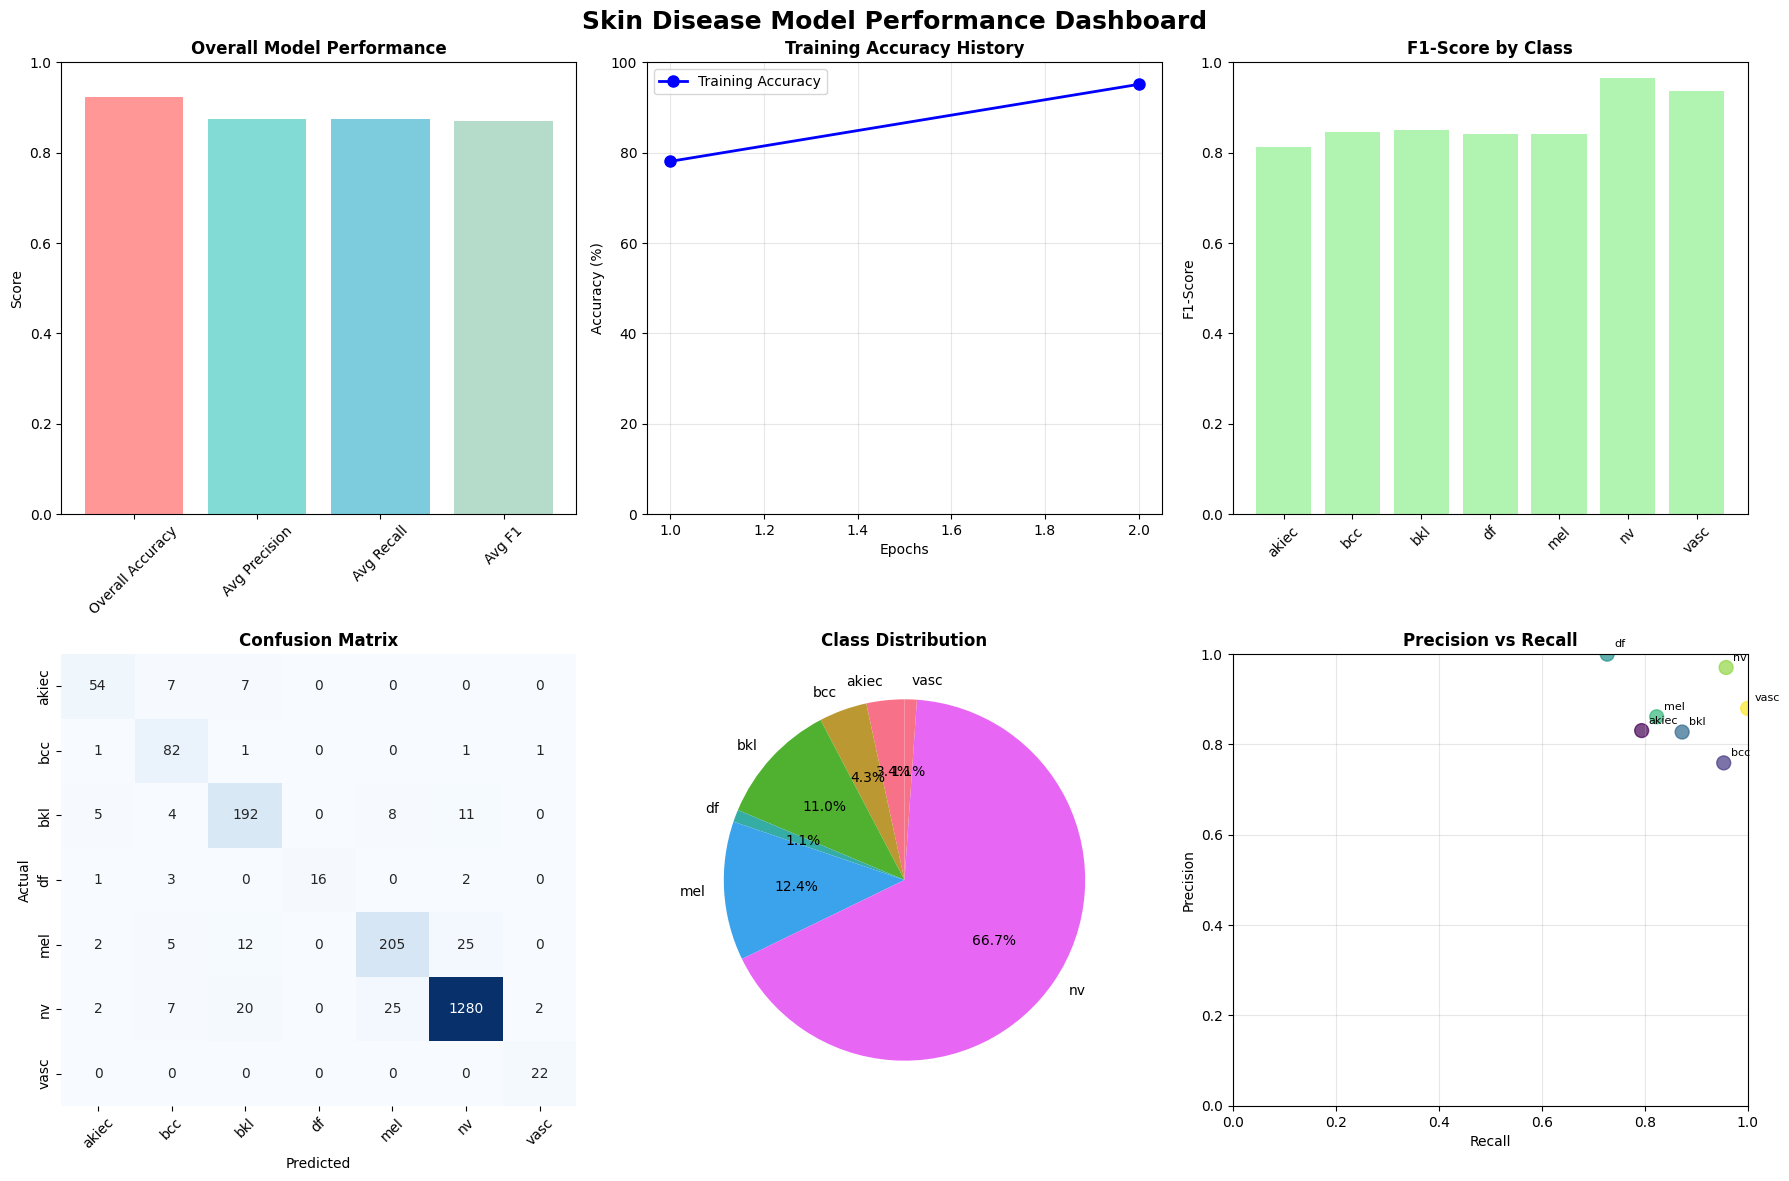

âœ… Comprehensive model performance analysis complete!


In [8]:
# Create a comprehensive performance dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Skin Disease Model Performance Dashboard', fontsize=18, fontweight='bold')

# 1. Overall metrics summary
axes[0, 0].bar(['Overall Accuracy', 'Avg Precision', 'Avg Recall', 'Avg F1'], 
              [overall_accuracy, np.mean(precision), np.mean(recall), np.mean(f1)], 
              color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'], alpha=0.7)
axes[0, 0].set_title('Overall Model Performance', fontweight='bold')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Training history
axes[0, 1].plot(epochs, train_accuracies, 'b-o', linewidth=2, markersize=8, label='Training Accuracy')
axes[0, 1].set_title('Training Accuracy History', fontweight='bold')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim(0, 100)

# 3. Per-class F1 scores
bars = axes[0, 2].bar(classes, f1, color='lightgreen', alpha=0.7)
axes[0, 2].set_title('F1-Score by Class', fontweight='bold')
axes[0, 2].set_ylabel('F1-Score')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].set_ylim(0, 1)

# 4. Confusion matrix heatmap (smaller version)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes, cbar=False, ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix', fontweight='bold')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].tick_params(axis='x', rotation=45)

# 5. Class distribution
class_counts = cm.sum(axis=1)
axes[1, 1].pie(class_counts, labels=classes, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Class Distribution', fontweight='bold')

# 6. Precision vs Recall scatter
axes[1, 2].scatter(recall, precision, c=range(len(classes)), cmap='viridis', s=100, alpha=0.7)
axes[1, 2].set_xlabel('Recall')
axes[1, 2].set_ylabel('Precision')
axes[1, 2].set_title('Precision vs Recall', fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].set_xlim(0, 1)
axes[1, 2].set_ylim(0, 1)

# Add class labels to scatter plot
for i, class_name in enumerate(classes):
    axes[1, 2].annotate(class_name, (recall[i], precision[i]), xytext=(5, 5), 
                        textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

print("âœ… Comprehensive model performance analysis complete!")

## 6. Save Results

In [9]:
# Save results to files
import json
from datetime import datetime

# Save metrics to JSON
results = {
    'timestamp': datetime.now().isoformat(),
    'overall_accuracy': float(overall_accuracy),
    'average_precision': float(np.mean(precision)),
    'average_recall': float(np.mean(recall)),
    'average_f1': float(np.mean(f1)),
    'per_class_metrics': metrics_df.to_dict('records'),
    'confusion_matrix': cm.tolist(),
    'classes': classes,
    'training_history': {
        'epochs': epochs,
        'train_accuracies': train_accuracies
    }
}

with open('model_performance_results.json', 'w') as f:
    json.dump(results, f, indent=2)

# Save metrics dataframe to CSV
metrics_df.to_csv('per_class_performance.csv', index=False)

print("âœ… Results saved to 'model_performance_results.json' and 'per_class_performance.csv'")

âœ… Results saved to 'model_performance_results.json' and 'per_class_performance.csv'
